# Topic Modeling with Amazon Comprehend

Let's explore output from Amazon's Comprehend LDA-based model.

## Preliminaries

### Data Loading

In [1]:
from collections import defaultdict
import csv
import os

%load_ext autoreload

Amazon Comprehend outputs two files: `topic-terms.csv` and `doc-typics.csv`. `topic-terms.csv` gives the top *n* terms for each topic. Every term has a weight. `doc-topics.csv` maps from topic to document. Documents are assigned probability values for a varying number of topics.

In [2]:
TOPIC_TERM_FILE = 'topic-terms.csv'
DOCUMENT_TOPIC_FILE = 'doc-topics.csv'

First, we'll create a function that names each topic. We'll choose the top *n* terms for each cluster.

In [3]:
def read_topic_terms(directory, n_terms=2):
    topic_terms = defaultdict(dict)
    for row in read_csv(directory, TOPIC_TERM_FILE):
        topic, term, weight = row
        topic_terms[int(topic)][term] = float(weight)
    return {topic: ', '.join(sorted(terms, key=terms.get, reverse=True)[:n_terms])
            for topic, terms in topic_terms.items()}

def read_csv(directory, file):
    with open(os.path.join(directory, file)) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip header
        for row in reader:
            yield row

In [99]:
read_topic_terms('../output/comprehend/VMwareLastMonth10Topics')

{0: 'host, esxi',
 1: 'vm, file',
 2: 'host, storage',
 3: 'disk, space',
 4: 'virtual, snapshot',
 5: 'service, start',
 6: 'upgrade, esxi',
 7: 'server, service',
 8: 'esxi, host',
 9: 'network, vms'}

Next up, let's write a function that maps from topic ID to session ID.

In [4]:
def read_document_map(directory, n_topics, n_terms=2):
    topic_to_session = [[] for _ in range(n_topics)]
    for row in read_csv(directory, DOCUMENT_TOPIC_FILE):
        doc_name, topic, _ = row
        _, session_id = parse_doc_name(doc_name)
        topic_to_session[int(topic)].append(session_id)
    return topic_to_session

def parse_doc_name(doc_name):
    filename, _ = os.path.splitext(doc_name)
    timestamp, session_id = filename.split('-', 1)
    return timestamp, session_id

In [139]:
topic_to_session = read_document_map('../output/comprehend/VMwareLastMonth10Topics', 10)

In [140]:
[len(topic_to_session[topic_id]) for topic_id in range(10)]

[2215, 1452, 1443, 1490, 802, 235, 484, 79, 74, 736]

Lastly, let's write functions that find deflection and click rates for each topic:

In [5]:
import sys
sys.path.append('..')
from scripts.elasticsearch_utils import find_deflected_sessions, generate_click_map

In [6]:
DEFLECTED_SESSIONS = find_deflected_sessions()
CLICK_COUNTS = generate_click_map()

In [7]:
def find_deflection_rates(topic_to_session):
    return [average([session_id in DEFLECTED_SESSIONS for session_id in session_ids])
            for session_ids in topic_to_session]

def find_click_rates(topic_to_session):
    return [average([CLICK_COUNTS[session_id] for session_id in session_ids])
            for session_ids in topic_to_session]

def average(values):
    if len(values) == 0:
        return 0
    return sum(values) / float(len(values))

### Graphing Functions

In [8]:
import random
import numpy
import matplotlib.pyplot as plt

First up a *count histogram*. This chart will display the number of documents within each topic.

In [9]:
def show_count_histogram(directory, title, n_topics):
    topic_to_session = read_document_map(directory, n_topics)
    counts = [len(session_ids) for session_ids in topic_to_session]
    plt.hist(counts, color='grey')
    plt.title(title)
    plt.xlabel('Number of Searches')
    plt.show()

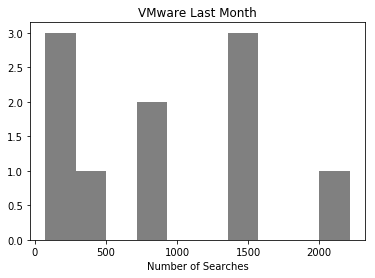

In [118]:
show_count_histogram('../output/comprehend/VMwareLastMonth10Topics', "VMware Last Month", 10)

Secondly, let's create a function that shows a bubble chart of topics along with their average click rate and deflection rate.

In [10]:
def show_bubbles(directory, n_topics, x_min=None, x_max=None, size=(15, 10), scale=5):
    topic_to_session = read_document_map(directory, n_topics)
    deflection_rates = find_deflection_rates(topic_to_session)
    click_rates = find_click_rates(topic_to_session)
    counts = [len(session_ids) * scale for session_ids in topic_to_session]
    
    plt.figure(figsize=size)
    plt.scatter(deflection_rates, click_rates, s=counts, alpha=0.5)
    for topic_id, name in read_topic_terms(directory, 3).items():
        deflection_rate = deflection_rates[topic_id]
        click_rate = click_rates[topic_id]
        plt.text(deflection_rate, click_rate, name, size=10, horizontalalignment='center')
    if x_min and x_max:
        plt.xlim(x_min, x_max)
    plt.xlabel("Deflection")
    plt.ylabel("Average Clicks")
    plt.show()

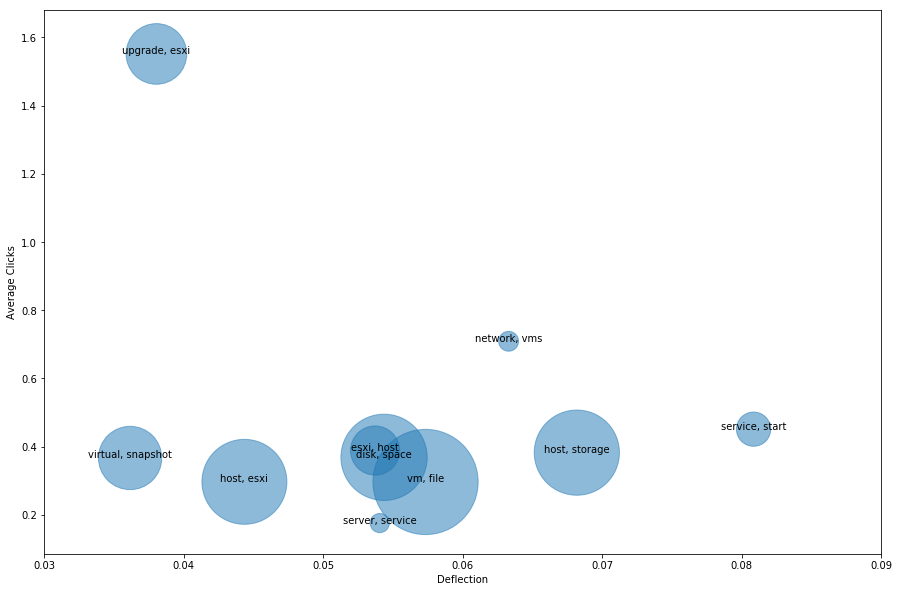

In [298]:
show_bubbles('../output/comprehend/VMwareLastMonth10Topics', 10)

In [300]:
from scripts.export_bubble import deflection_vs_click

In [301]:
topic_to_session = read_document_map('../output/comprehend/VMwareLastMonth10Topics', 10)
deflection_rates = find_deflection_rates(topic_to_session)
click_rates = find_click_rates(topic_to_session)
counts = [len(session_ids) for session_ids in topic_to_session]
names = list(read_topic_terms('../output/comprehend/VMwareLastMonth10Topics', 3).values())

deflection_vs_click(names, counts, click_rates, deflection_rates)

## 10 Topics

In the first of four modeling jobs, I ran Comprehend on a month's worth of VMware last-chance searches. For this job, I set the number if topics to 10. Amazon Comprehend's output can be found in `output/VMwareLastMonth10Topics`.

In [11]:
directory = '../output/comprehend/VMwareLastMonth10Topics'

Let's load these CSVs into memory using the functions we defined above.

In [113]:
key_terms = read_topic_terms(directory, 4)
topic_to_sessions = read_document_map(directory, 10)

In [114]:
import pandas as pd

pd.DataFrame([{'Key Terms': terms, 'Size': len(topic_to_sessions[topic_id])}
              for topic_id, terms in key_terms.items()])

,Key Terms,Size
0,"host, esxi, vcenter, disconnect",2215
1,"vm, file, error, fail",1452
2,"host, storage, cluster, datastore",1443
3,"disk, space, vsan, datastore",1490
4,"virtual, snapshot, window, nsx",802
5,"service, start, vcenter, screen",235
6,"upgrade, esxi, version, vcenter",484
7,"server, service, start, error",79
8,"esxi, host, purple, screen",74
9,"network, vms, snapshot, power",736


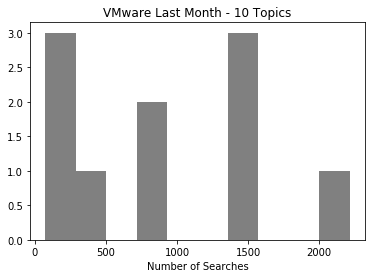

In [115]:
show_count_histogram(directory, "VMware Last Month - 10 Topics", 10)

Documents are not spread evenly over the topics. Some topics are quite large (`0` has 2215 documents) some are quite small (`8` has 74 documents). Note that a single document can be in more than one topic; the sum of the topic sizes is larger than the total number of documents.

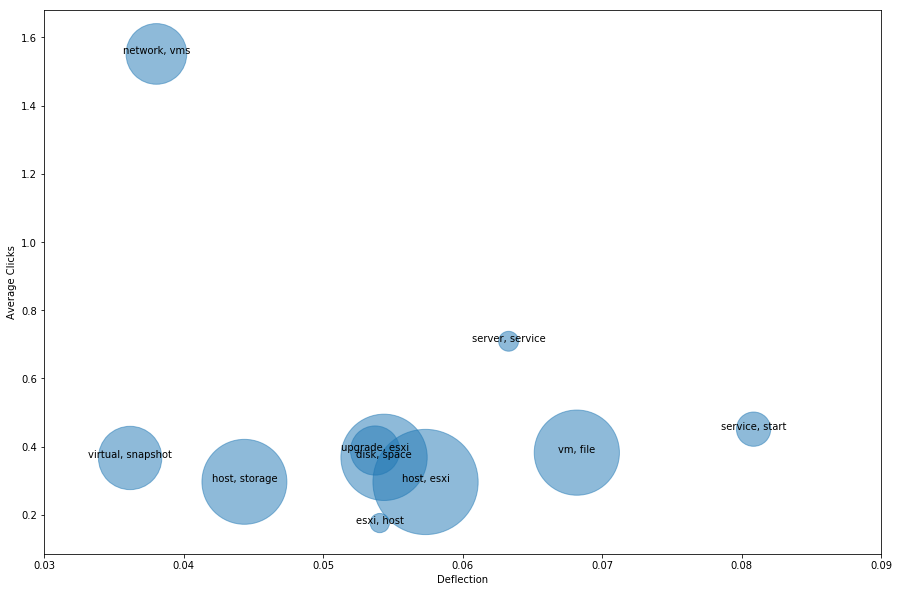

In [120]:
show_bubbles(directory, 10, x_min=0.03, x_max=0.09)

Based on this chart, `upgrade, esxi` has higher than average engagement, but lower than average deflection.

Lastly, let's export all topics and their sessions to a CSV:

In [49]:
from scripts import corpora

def export_sessions(output_path, corpus, topic_to_sessions, key_terms):
    session_to_body = {search.session_id: search.body
                       for search in corpora.load(corpus)}
    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Topic ID', 'Key Topic Terms', 'Session ID', 'Body'])
        for topic_id in range(len(topic_to_sessions)):
            for session_id in topic_to_sessions[topic_id]:
                body = session_to_body[session_id]
                writer.writerow([topic_id, key_terms[topic_id], session_id, body])

In [51]:
export_sessions('comprehend-one-month-ten-topics.csv', '../corpora/vmware-last-month', topic_to_sessions, key_terms)

## 25 Topics

In [122]:
directory = '../output/comprehend/VMwareLastMonth25Topics'
key_terms = read_topic_terms(directory, 4)
topic_to_sessions = read_document_map(directory, 25)

In [123]:
import pandas as pd

pd.DataFrame([{'Key Terms': terms, 'Size': len(topic_to_sessions[topic_id])}
              for topic_id, terms in key_terms.items()])

,Key Terms,Size
0,"nsx, manager, upgrade, fail",1231
1,"disk, space, show, vsan",1030
2,"cluster, vsan, disk, health",1404
3,"vmware, update, install, tool",980
4,"client, vcenter, web, vsphere",1402
5,"network, host, lose, connectivity",550
6,"snapshot, delete, machine, virtual",345
7,"file, fail, lock, unable",262
8,"unable, fail, crash, issue",1124
9,"certificate, status, alarm, ssl",149


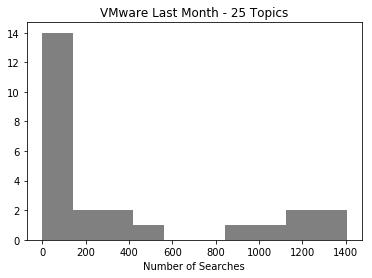

In [124]:
show_count_histogram(directory, "VMware Last Month - 25 Topics", 25)

Interestingly, some topics have zero documents in Comprehend's output.

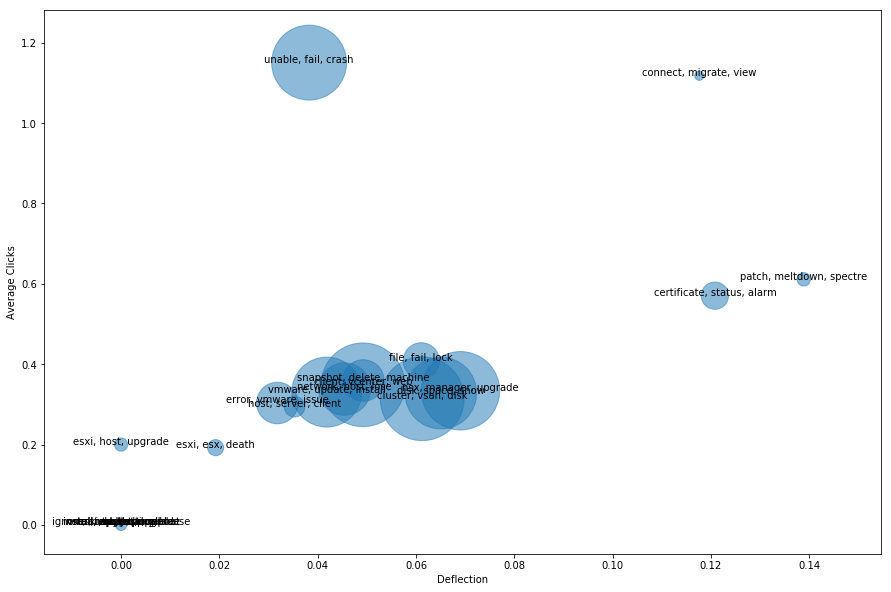

In [127]:
show_bubbles(directory, 25)

## 50 Topics

In [12]:
directory = '../output/comprehend/VMwareLastMonth25Topics'
key_terms = read_topic_terms(directory, 4)
topic_to_sessions = read_document_map(directory, 50)

In [13]:
import pandas as pd

pd.DataFrame([{'Key Terms': terms, 'Size': len(topic_to_sessions[topic_id])}
              for topic_id, terms in key_terms.items()])

,Key Terms,Size
0,"disk, space, show, appliance",775
1,"user, password, login, unable",664
2,"support, open, casar, request",808
3,"datastore, unable, add, increase",428
4,"vcsa, fail, upgrade, connect",534
5,"network, storage, access, datastore",990
6,"change, ip, address, vcenter",276
7,"host, vsphere, error, agent",445
8,"vm, cpu, high, server",248
9,"vmotion, issue, window, add",919


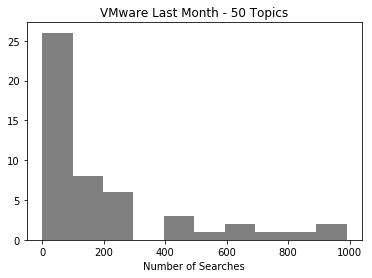

In [14]:
show_count_histogram(directory, "VMware Last Month - 50 Topics", 50)

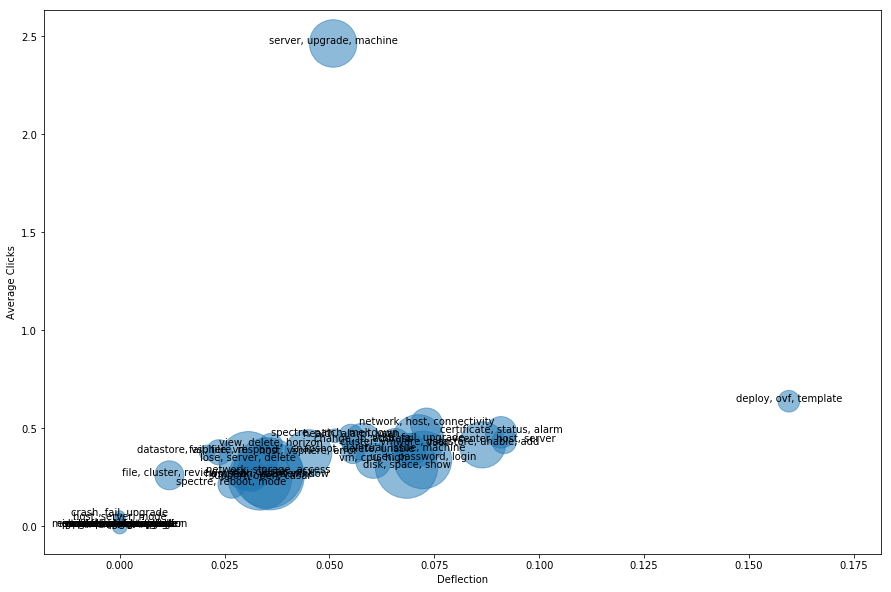

In [15]:
show_bubbles(directory, 50)